# Particle tracking with MODFLOW 6 and MODPATH 7

A model is "solved" once convergence is achieved for steady state or transient head values. As we've seen in the class so far, this means we can create outputs that show changes in head over time at points in space or throughout the model domain.

Often, however, the prediction of interest for a model is something different than head values at a point in space. For example, we may want to know how quickly a lake is losing water to pumping, and how that changes as pumping rates change. Or, we may want to understand the source for water entering a particular region (such as the source of water entering a well).

Thes notebook demonstrates particle tracking with MODFLOW 6 using the associated particle tracking code MODPATH 7. This example is similar to an example in the MODPATH 7 user guide examples
document ([Pollock, 2016](http://dx.doi.org/10.3133/ofr20161086)).

The flow system consists of two aquifers with a low conductivity
confining layer in between. The model grid is roughly square. There is
a quad-refined region around a central well and a river runs along the
grid's eastern boundary.

Particles are released from the inside of the cell containing the well and tracked
backwards to recharge points at the water table.


**Notes**:
The codes that can be used for particle tracking are in a bit of "flux" (pun intended), with new capabilities for MODFLOW 6 actively being developed. The following provides some guidelines on how to handle particle tracking with current and historical models:

* MODFLOW-2005: Users of MODFLOW-2005 must use MODPATH 6, with associated functions found under `flopy.modpath.ModPath6`.
* MODFLOW 6:
   * For rectangular / plaid grids or quadtree grids, MODPATH 7 can be used. Associated FloPy functions are found under `flopy.modpath.ModPath7`
   * For more unstructured grids, the MODFLOW 6 PRT (Particle tracking) provides a more flexible method for particle tracking. However, note that this was only recently released (May 23, 2024), and the most recent release of MODFLOW 6 version 6.6 indicates that [there are many bugs still being squashed](https://water.usgs.gov/water-resources/software/MODFLOW-6/release_6.6.0.pdf)

This notebook was started from a version of the [2024 MODFLOW training notebooks](https://github.com/christianlangevin/modflow-training-princeton2024/tree/main/examples/notebooks) offered by Christian Langevin.

## Learning Objectives

After you have read and run this notebook, you should be able to:
* Setup MODPATH 7 to run using the results from a MODFLOW 6 model
* Define options for particle tracking including particle release locations, particle travel directions, and MODPATH output

## Initial Setup

As usual, we will import all necessary packages used in this workbook first.

In [1]:
#Note - Pathlib is an alternative to os.path
import pathlib as pl

import flopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from flopy.utils.gridgen import Gridgen
from flopy.utils.gridintersect import GridIntersect
from flopy.discretization import VertexGrid
import flopy.discretization as fpd
from flopy.utils.triangle import Triangle as Triangle
from flopy.utils.voronoi import VoronoiGrid
from shapely.geometry import LineString, Point, MultiPoint, Polygon
from matplotlib import colormaps as cm

#Define the base workspace where output will be generated
example_name = "tracking"
base_ws = pl.Path("nboutput") / example_name

## 1. Setup of Base grid & Quadtree refinement

Our first step is to create a quad-refined grid. For this we will use the [GRIDGEN](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids) program.

The grid will have 3 refinement levels. First we create a regular structured grid discretization to use as a base for refinement.

In [2]:
#1A - Setup Base Grid

#Model Properties
length_units = "feet"
time_units = "days"

# Base grid properties
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr_reg = Lx / ncol*np.ones((ncol))
delc_reg = Ly / nrow*np.ones((nrow))
top_reg = 400*np.ones((nrow, ncol))
botm_reg = np.stack((220*np.ones((nrow,ncol)), 200*np.ones((nrow,ncol)), 0*np.ones((nrow,ncol))),0)

# Create an initial regularly-discretized grid as a modelgrid object
modelgrid_reg = fpd.StructuredGrid(
    delc=delc_reg,
    delr=delr_reg,
    nrow=nrow,
    ncol=ncol,
    nlay=nlay,
    top=top_reg,
    botm=botm_reg,
)

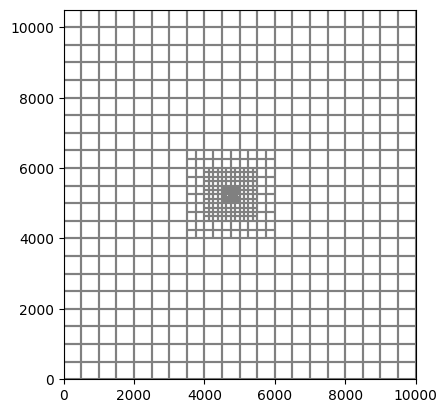

In [3]:
#1B - Create refined modelgrid with quadtree

# Create gridgen workspace and object
gridgen_ws = base_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)
gridgen = Gridgen(modelgrid_reg, model_ws=gridgen_ws)

# Define refinement polygons
ref_polys = [
    [[(3500, 4000), (3500, 6500), (6000, 6500), (6000, 4000), (3500, 4000)]],  # outer
    [[(4000, 4500), (4000, 6000), (5500, 6000), (5500, 4500), (4000, 4500)]],  # middle
    [[(4500, 5000), (4500, 5500), (5000, 5500), (5000, 5000), (4500, 5000)]],  # inner
]

#Go through in order -- each level is a lower level of refinement.
for i, poly in enumerate(ref_polys):
    gridgen.add_refinement_features([poly], "polygon", i + 1, range(nlay))

# Build the refined grid and plot it
gridgen.build(verbose=False)
grid_props = gridgen.get_gridprops_vertexgrid()
disv_props = gridgen.get_gridprops_disv()
grid = flopy.discretization.VertexGrid(**grid_props)
grid.plot()

# Extract refined grid properties as later needed inputs
ncpl = disv_props["ncpl"]
top = disv_props["top"]
botm = disv_props["botm"]
nvert = disv_props["nvert"]
vertices = disv_props["vertices"]
cell2d = disv_props["cell2d"]

## 2. Define the setup and stresses for the groundwater flow model

We are ready to create the groundwater flow model. First, we define the model name, workspace, units, and parameters associated with stress packages and time stepping. The River and Well package values are defined as grid-independent so that the properties can be mapped onto the appropriate grid square

In [4]:
#Define the model name and workspace.
gwf_name = f"{example_name}-gwf"
gwf_ws = base_ws / "gwf"
gwf_ws.mkdir(exist_ok=True, parents=True)

#Stress package properties and geometry
rrch = 0.005  # Recharge rate ($ft/d$)
kh = [50.0, 0.01, 200.0]  # Horizontal hydraulic conductivity ($ft/d$)
kv = [10.0, 0.01, 20.0]  # Vertical hydraulic conductivity ($ft/d$)

wel_coords = [(4718.45, 5281.25)]
wel_layer = 2
wel_q = -150000.0  # Well pumping rate ($ft^3/d$)

riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)
riv_layer = 0
riverline = [(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]
porosity = 0.1  # Soil porosity (unitless)

#Define the time discretization
nstp = 1
perlen = 1000.0
tsmult = 1.0
tdis_rc = [(perlen, nstp, tsmult)]

As usual, we first populate all the required packages for a MODFLOW 6 model, which includes:
* The SIMulation level information
* The model solver (IMS) parameters
* The model(s) solved within the simulation (this time, a single GWF package)
* The TDIS (Time discretization) package
* The discretization (DISV, in this case)
* The initial conditions (IC)
* The aquifer properties (NPF)

In [5]:
sim = flopy.mf6.MFSimulation(
    sim_name=gwf_name, 
    exe_name="mf6", 
    version="mf6", 
    sim_ws=gwf_ws
)
tdis = flopy.mf6.ModflowTdis(
    sim, 
    time_units=time_units, 
    perioddata=tdis_rc, 
    nper=len(tdis_rc)
)

# Create the iterative model solution (IMS) package and register it with the model.
ims = flopy.mf6.ModflowIms(
    sim,
    outer_dvclose=1.0e-5,
    outer_maximum=100,
    under_relaxation="NONE",
    inner_maximum=100,
    inner_dvclose=1.0e-6,
    rcloserecord=0.1,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.99,
)

gwf = flopy.mf6.ModflowGwf(
    sim, 
    modelname=gwf_name, 
    model_nam_file="{}.nam".format(gwf_name)
)
gwf.name_file.save_flows = True

disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    length_units=length_units,
    **disv_props,  # from grid refinement above
)
ic = flopy.mf6.ModflowGwfic(
    gwf, 
    strt=riv_h)  # initial head throughout the model is set at the river stage value

npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=[("xt3d")],
    icelltype=[1, 0, 0],
    k=kh,
    k33=kv,
    save_saturation=True,
    save_specific_discharge=True,
)

headfile_name = "{}.hds".format(gwf_name)
budgetfile_name = "{}.cbb".format(gwf_name)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=[budgetfile_name],
    head_filerecord=[headfile_name],
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

sim.register_ims_package(ims, [gwf.name])


Next, we map the model boundary conditions onto the grid using `intersects` functionality for the River and Well packages. Recharge is assumed constant over the grid

In [6]:
# Create intersection utility
ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)

#Intersect the well coordinates with the model grid.
welcells = ix.intersects(MultiPoint(wel_coords))
welcells = [icpl for (icpl,) in welcells]
welspd = [[(wel_layer, icpl), wel_q] for icpl in welcells]

wel = flopy.mf6.ModflowGwfwel(
    gwf, 
    print_input=True, 
    stress_period_data=welspd
)

# Intersect the well line with the model grid.
rivcells = ix.intersects(LineString(riverline))
rivcells = rivcells.cellids.tolist()
rivspd = [
    [(riv_layer, icpl), riv_h, riv_c, riv_z] for icpl in rivcells
]

riv = flopy.mf6.ModflowGwfriv(
    gwf, 
    stress_period_data=rivspd
)

# Create the recharge package
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=rrch,
)

## Step 3: Run MODFLOW

Next, we run the modflow simulation to generate head and flux data

In [7]:
sim.write_simulation(silent=False)
sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model tracking-gwf...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package rcha_0...
FloPy is using the following executable to run the model: ../../../../../../../../opt/anaconda3/envs/geosci724/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

        MODFLOW 6 compiled Dec 23 2024 16:29:44 with GCC version 12.4.0

This software has been approved for release by t

(True, [])

## 4. Check the MODFLOW results

Before going further, it is a good idea to ensure that the head data seems reasonable, i.e., verifying:
* Stresses are setup correctly
* The model appears to have converged

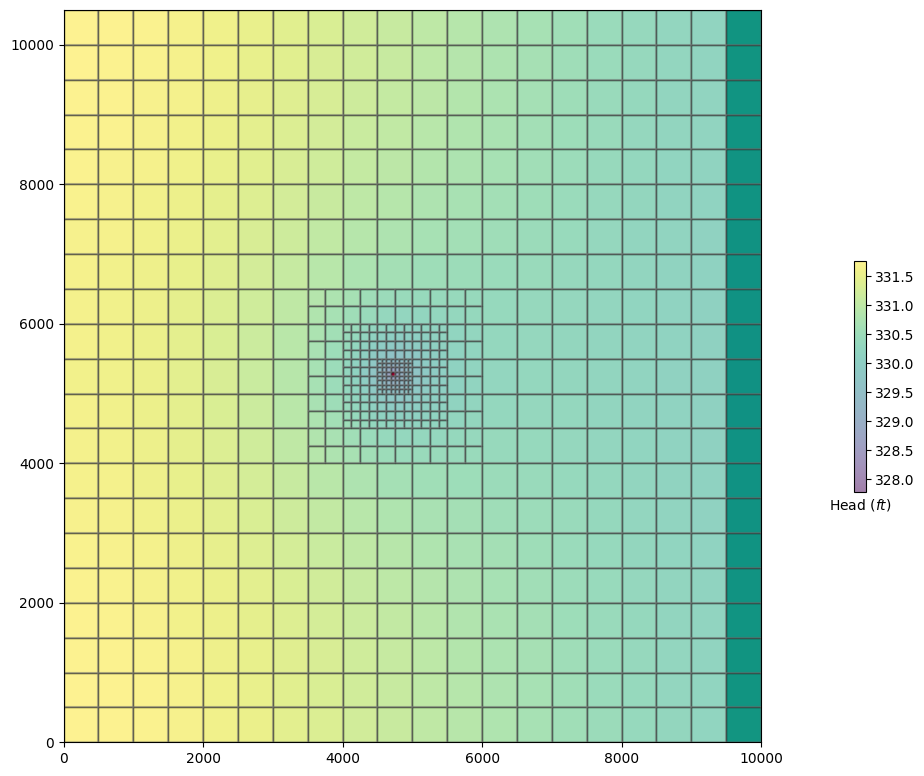

In [8]:
#Plot A map-view map including heads, boundary conditions.

hds = gwf.output.head().get_data()

fig = plt.figure(figsize=(12, 12))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
mm.plot_grid(alpha=0.25)
mm.plot_bc("WEL", plotAll=True, color="red")
mm.plot_bc("RIV", plotAll=True, color="teal")
pc = mm.plot_array(hds[:, 0, :], edgecolor="black", alpha=0.5)
cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
cb.ax.set_xlabel(r"Head ($ft$)")
plt.show()

## 5. Setup MODPATH inputs

Next, we can create a MODPATH 7 particle tracking model using the flow model we just created. 

The key inputs for MODFLOW 7 are entered in packages, similar to MODFLOW:
* MODPATH 7 BAS Package: defines necessary parameters for simulating transport beyond those provided in MODFLOW. Porosity is the key parameter needed here
* MODPATH 7 SIMulation-level information: This includes information about where particles start, which direction you would like to track particles (forwards or backwards), how long you would like to track particles, and how you would like results to be output 


In [9]:
#5A - Define name and workspace where all modpath files will be stored, as well as where to pull flux and head data from.
mp7_name = f"{example_name}-mp7"
mp7_ws = base_ws / "mp7"
mp7_ws.mkdir(exist_ok=True, parents=True)

mp7_sim = flopy.modpath.Modpath7(
    modelname=mp7_name,
    flowmodel=gwf,
    exe_name="mp7",
    model_ws=mp7_ws,
    budgetfilename=budgetfile_name,
    headfilename=headfile_name,
)

In [10]:
#5B Define the package inputs for MODPATH, in the BAS and SIM file.

mp7_bas = flopy.modpath.Modpath7Bas(mp7_sim, porosity=porosity)

#Setup the starting locations of particles. 
#For MODPATH 7, we must provide the model cell (node) from which particles will be released, as well as subdivision data on 
#where particles will be released within each node. The default is to release 27 particles per node in a 3 x 3 x 3
#grid inside each model cell
particle_data = flopy.modpath.NodeParticleData(
    nodes=ncpl * wel_layer + welcells[0],
    subdivisiondata=None
)

#Particles must be assigned to a particle group. This allows features such as tracking well capture percentages.
particle_group = flopy.modpath.ParticleGroupNodeTemplate(
    particlegroupname="PG",
    particledata=particle_data,
    filename="pg.sloc",
)

mp7 = flopy.modpath.Modpath7Sim(
    mp7_sim,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    particlegroups=[particle_group],
)

## 6. Write and run the MP7 model.

In [11]:
mp7_sim.write_input()
mp7_sim.run_model(silent=False)

FloPy is using the following executable to run the model: ../../../../../../../../opt/anaconda3/envs/geosci724/bin/mp7

MODPATH Version 7.2.001   
Program compiled Feb 14 2025 13:41:09 with GFORTRAN compiler (ver. 12.4.0)      


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        27 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                 

(True, [])

## 8. Visualize MODPATH Outputs using the Pathline and Timeseries files

MODPATH Produces two types of outputs that are different mainly in the efficiency of accessing them:
* Pathline files contain the location of the particle at every step during the numerical simulation. It is organized by particle, so the full path of any individual particle can be plotted easily.
* Timeseries files contain the location of all particles at a series of time snapshots, specified by the user. It is organized by time, so the location of all particles at a given time can be plotted easily.

In [12]:
mp7_pathline_file = flopy.utils.PathlineFile(mp7_ws / f"{mp7_name}.mppth")

mp7_pathlines = mp7_pathline_file.get_alldata()
#TRY THIS:
#mp7_pathlines = mp7_pathline_file.get_alldata(totim=1000,ge=False)

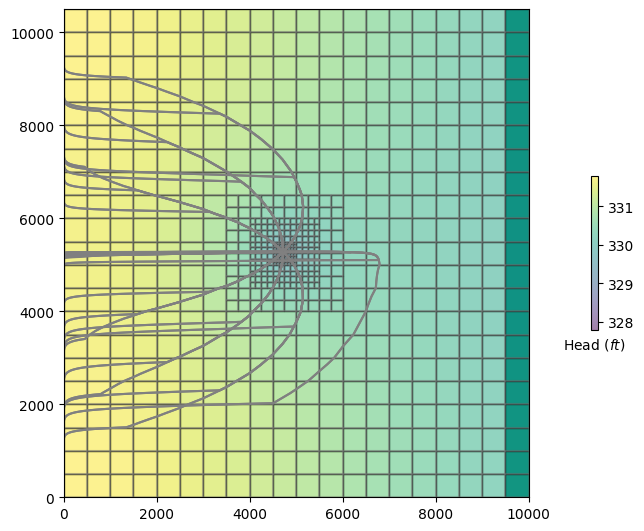

In [13]:
fig = plt.figure(figsize=(8, 8))
fig.tight_layout()
ax2 = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(gwf, ax=ax2, layer=2)
mm.plot_grid(alpha=0.25)
mm.plot_bc("WEL", plotAll=True, color="red")
mm.plot_bc("RIV", plotAll=True, color="teal")
pc = mm.plot_array(hds[:, 0, :], edgecolor="black", alpha=0.5)
cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
cb.ax.set_xlabel(r"Head ($ft$)")
mm.plot_pathline(mp7_pathlines, layer="all")
plt.show()

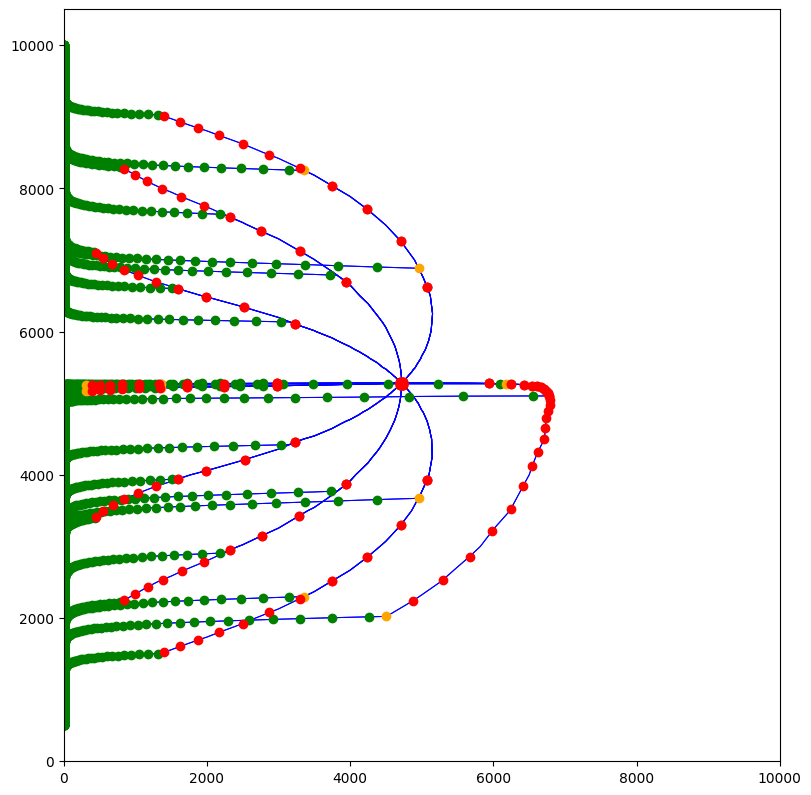

In [14]:
fpth = mp7_ws / f"{mp7_name}.timeseries"
ts = flopy.utils.TimeseriesFile(fpth)
#TRY THIS: Look at other things you can pull out of the timeseries data with ts.get_....
ts0 = ts.get_alldata()

fpth = mp7_ws / f"{mp7_name}.mppth"
p = flopy.utils.PathlineFile(fpth)
#TRY THIS: Look at other things you can pull out of the pathline data with p0.get_....
p0 = p.get_alldata()

fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(gwf, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)

mm.plot_pathline(p0, layer="all", colors="blue", lw=0.75)
colors = ["green", "orange", "red"]
for k in range(nlay):
    mm.plot_timeseries(ts0, layer=k, marker="o", lw=0, color=colors[k])

In [15]:
#FOR THE FUTURE: Cross-section pathlines look very strange!
# fig = plt.figure(figsize=(6, 6))
# ax2 = fig.add_subplot(1, 1, 1, aspect=20)
# cm = flopy.plot.PlotCrossSection(model=gwf, ax=ax2,line={"line": ((0,5000),(10000,5000))})
# cm.plot_pathline(mp7_pathlines,method="all")
# cm.plot_